# Bayes analysis of SIR model with changing points

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func

In [2]:
# setting the ground truths and the scenarios
gt_changing_points = [1, 26, 51, 76]

gt_total_time = 100

gt_betas = [0.10, 0.4, 0.2, 0.05]
gt_gammas = [0.01, 0.08, 0.15, 0.25]

gt_total_population = 1_000_000
gt_init_infected = 50

save_npz = True

gt_changing_points_tmp = gt_changing_points.copy()
gt_changing_points_tmp.append(gt_total_time + 1)
gt_days = np.array(gt_changing_points_tmp[1:]) - np.array(gt_changing_points_tmp[:-1])
gt_beta_time = np.concatenate(
    [[beta_val] * days for beta_val, days in zip(gt_betas, gt_days)]
)
gt_gamma_time = np.concatenate(
    [[gamma_val] * days for gamma_val, days in zip(gt_gammas, gt_days)]
)

In [3]:
# setting the lvectors for the simulations
S = np.zeros(gt_total_time + 1)
I = np.zeros(gt_total_time + 1)
R = np.zeros(gt_total_time + 1)
P = np.zeros(gt_total_time + 1)
N = np.zeros(gt_total_time + 1)

N[0] = gt_total_population
S[0] = N[0] - gt_init_infected
I[0] = gt_init_infected
R[0] = 0
P[0] = I[0] / N[0]

In [4]:
# generate the simulation
for i in range(1, gt_total_time + 1):
    delta_i = np.random.binomial(
        S[i - 1], 1 - np.exp(-gt_beta_time[i - 1] * P[i - 1]))
    delta_r = np.random.binomial(I[i - 1], gt_gamma_time[i - 1])

    S[i] = S[i - 1] - delta_i
    I[i] = I[i - 1] + delta_i - delta_r
    R[i] = R[i - 1] + delta_r
    N[i] = S[i] + I[i] + R[i]
    P[i] = I[i] / N[i]

# save the simulation
if save_npz:
    np.savez(
        "gt_data.npz",
        S=S,
        I=I,
        R=R,
    )

In [5]:
# load the simulation data
simulation = np.load('gt_data.npz')

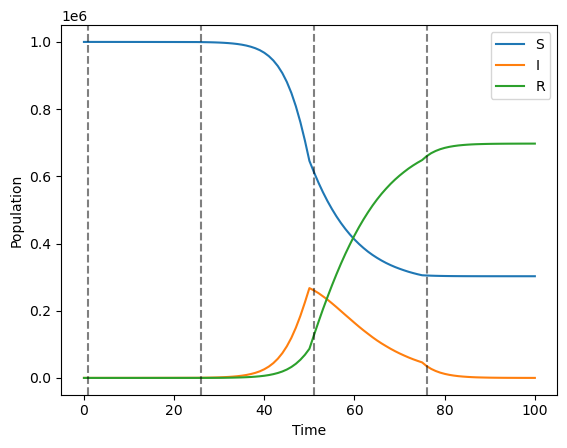

In [6]:
# plot the data
def plot_population_data(S, R, I, gt_changing_points):
    """
    Plots the population data for susceptible (S), recovered (R), and infected (I) individuals over time.

    Parameters:
    S (array-like): Array of susceptible population counts over time.
    R (array-like): Array of recovered population counts over time.
    I (array-like): Array of infected population counts over time.

    Returns:
    None
    """
    plt.plot(S, label="S")
    plt.plot(I, label="I")
    plt.plot(R, label="R")
    for c_point in gt_changing_points:
        plt.axvline(x=c_point, color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.legend()
    plt.show()


plot_population_data(S, R, I, gt_changing_points)

# MCMC algorithm

## Data preparation

In [7]:
# reshape and prepare the data
R = simulation["R"]
S = simulation["S"]
I = simulation["I"]

T = R.shape[0] - 1
S_0 = S[0]
I_0 = I[0]
R_0 = R[0]
N_0 = S_0 + I_0 + R_0
S = S[1:]
R = R[1:]
I = I[1:]

P_0 = I_0 / N_0
P = I / N_0

delta_R = R[1:] - R[:-1]
delta_R = np.concatenate([[R[0] - R_0], delta_R])

delta_I = S[:-1] - S[1:]
delta_I = np.concatenate([[S_0 - S[0]], delta_I])

print("Modified length", R.shape)
print("T", T)

Modified length (100,)
T 100


In [8]:
# mcmc hyperparameters
N = 15_000  # n samplings
burnin = 5000
thinning = 10
p = 0.01

## Algorithm parameters

In [9]:
betas = np.zeros([N, T])
gammas = np.zeros([N, T])
bs = np.zeros([N, T])
rs = np.zeros([N, T])
deltas = np.zeros([N, T])

In [10]:
# init
delta_0 = np.random.binomial(1, p, size=T)
delta_0[0] = 1
K_0 = np.sum(delta_0)
eta_0 = np.cumsum(delta_0)

# vectors of K elements
r_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)
b_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)

r_0 = r_0[eta_0-1]
b_0 = b_0[eta_0-1]

beta_0 = np.random.exponential(1/b_0)
gamma_0 = np.random.beta(r_0, 1)

In [11]:
delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()

In [12]:
def add(delta):
    _delta = delta.copy()
    index = np.random.choice(np.where(_delta == 0)[0])
    _delta[index] = 1
    return _delta


def delete(delta):
    _delta = delta.copy()
    index = np.random.choice(np.where(_delta[1:] == 1)[0]) + 1
    _delta[index] = 0
    return _delta


def swap(delta):
    _delta = delta.copy()
    index = np.random.choice(
        np.where(_delta[1: T - 1] - _delta[2:T] != 0)[0]) + 1
    _delta[index] = 1 - _delta[index]
    _delta[index + 1] = 1 - _delta[index + 1]

    return _delta

In [13]:
def propose_delta(delta):
    delta_orig = delta.copy()
    _K = np.sum(delta_orig)
    if _K == 1:
        delta_ = add(delta_orig)
    elif _K == T:
        delta_ = delete(delta_orig)
    else:
        rand_choice = np.random.random()
        if rand_choice < 1 / 3:
            delta_ = add(delta_orig)
        elif rand_choice < 2 / 3:
            delta_ = delete(delta_orig)
        else:
            delta_ = swap(delta_orig)

    return delta_.copy()

In [14]:
def log_j_ratio(sum_candidate, sum_original):
    if sum_original == sum_candidate:
        return 0  # np.log(1)
    elif (sum_candidate, sum_original) == (1, 2) or (sum_candidate, sum_original) == (T, T-1):
        return np.log(3/(T-1))
    elif (sum_candidate, sum_original) == (2, 1) or (sum_candidate, sum_original) == (T-1, T):
        return np.log((T-1)/3)
    elif sum_candidate == (sum_original-1):
        return np.log((sum_original-1)/(T-sum_candidate))
    else:
        return np.log((T-sum_original)/(sum_candidate-1))

In [15]:
def safe_log(x):
    x = np.array(x)
    mask = x > 1e-16
    output = np.zeros(x.shape)
    output[mask] = np.log(x[mask])
    output[~mask] = -1000
    return output

In [16]:
def log_likelihood(delta, beta, gamma):
    _delta = delta.copy()
    eta = np.cumsum(_delta)
    K = np.sum(_delta, dtype=int)

    total = 0
    for i in range(1, K + 1):
        indic = eta == i
        _n = np.sum(indic)
        _sum_gamma = np.sum(safe_log(gamma[indic]))
        _sum_beta = np.sum(beta[indic])
        total += 0.2 * safe_log(0.1) - 2 * safe_log(gamma_func(0.1))
        total += 2 * safe_log(gamma_func(0.1 + _n)) - _sum_gamma
        total += -(0.1 + _n) * (safe_log(0.1 + _sum_beta) +
                                safe_log(0.1 - _sum_gamma))

    return total

In [17]:
def accept_delta(delta_original, delta_candidate, beta, gamma):
    exponent = np.sum(delta_candidate - delta_original)
    prior_ratio = exponent * np.log(p / (1 - p))
    sum_candidate = np.sum(delta_candidate)
    sum_original = np.sum(delta_original)
    j_ratio = log_j_ratio(sum_candidate, sum_original)
    likelihood_ratio = log_likelihood(delta_candidate, beta, gamma) - log_likelihood(
        delta_original, beta, gamma
    )

    mh_log = prior_ratio + likelihood_ratio + j_ratio

    prob = min(0, mh_log)

    random_num = np.log(np.random.random())

    if random_num < prob:
        return delta_candidate
    else:
        return delta_original

In [18]:
def update_b(delta, beta):
    K = np.sum(delta)
    b = np.zeros(K)
    eta = np.cumsum(delta)
    for k in range(1, K + 1):
        b[k - 1] = np.random.gamma(
            shape=0.1 + np.sum(eta == k),
            scale=1.0 / (0.1 + np.sum(beta[eta == k])),
        )

    return b[eta - 1]


def update_r(delta, gamma):
    K = np.sum(delta)
    r = np.zeros(K)
    eta = np.cumsum(delta)
    for k in range(1, K + 1):
        r[k - 1] = np.random.gamma(
            shape=0.1 + np.sum(eta == k),
            scale=1.0 / (0.1 - np.sum(safe_log(gamma[eta == k]))),
        )

    return r[eta - 1]

In [19]:
def update_beta(b):
    _beta = np.zeros(T)
    for t in range(T):
        if t != 0:
            y = np.random.beta(
                a=S[t - 1] - delta_I[t] + b[t] / P[t - 1] + 1,
                b=delta_I[t] + 1,
            )
            _beta[t] = -safe_log(y) / P[t - 1]
        else:
            _beta[t] = y = np.random.beta(
                a=S_0 - delta_I[t] + b[t] / P_0 + 1,
                b=delta_I[t] + 1,
            )
            _beta[t] = -safe_log(y) / P_0

    return _beta

In [20]:
def update_gamma( r):
    _gamma = np.zeros(T)
    for t in range(T):
        if t!=0:
            _gamma[t] = np.random.beta(
                a=delta_R[t] + r[t],
                b=1 + I[t-1] - delta_R[t],
            )
        else:
            _gamma[t] = np.random.beta(
                a=delta_R[t] + r[t],
                b=1 + I_0 - delta_R[t],
            )


    return _gamma

In [21]:
K = np.sum(delta)
eta = np.cumsum(delta)
for n in range(N):

    delta_ = propose_delta(delta)
    delta = accept_delta(delta, delta_, beta, gamma)

    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    beta = update_beta(delta)
    gamma = update_gamma(r)

    betas[n, :] = beta
    gammas[n, :] = gamma
    deltas[n, :] = delta
    rs[n, :] = r
    bs[n, :] = b

## Analysis of data

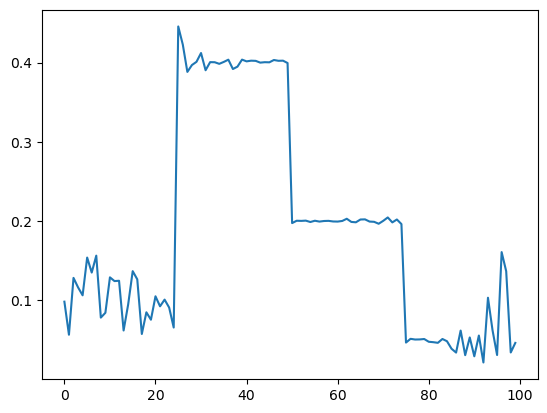

In [22]:
plt.plot(np.mean(betas[burnin::thinning,:],axis=0))

In [23]:
beta_samples = betas[burnin::thinning, :]
delta_samples = deltas[burnin::thinning, :]
b_samples = bs[burnin::thinning, :]
r_samples = rs[burnin::thinning, :]
eta_samples = np.cumsum(deltas, axis=1)

n_samples = eta_samples.shape[0]
q = np.zeros((T, T))
for n in range(n_samples):
    q += (eta_samples[n, :] == (eta_samples[n, :])[:, None]).astype(int)
q = q / n_samples

In [24]:
np.savez('q_marco', q=q)

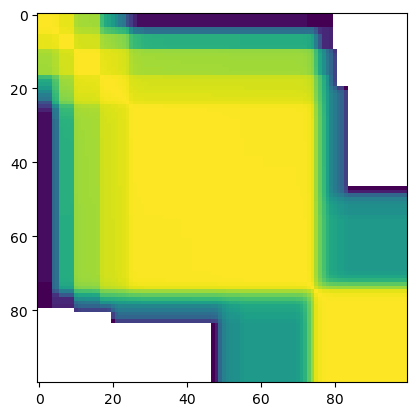

In [25]:
import matplotlib.colors as col
plt.imshow(q, norm=col.LogNorm())


In [26]:
delta_hat = np.array([0] * T)
delta_hat[0] = 1


eta_hat = np.cumsum(delta_hat)

continue_add = True
continue_swap = True



def loss(eta, q):
    return np.sum(np.abs((eta == eta[:, None]).astype(int) - q))




In [27]:
iteration = 0
current_loss = loss(eta_hat, q)

while continue_add or continue_swap:
    iteration += 1

    all_loss = []
    candidate_indexes = range(1, T)
    for i in candidate_indexes:

        delta_candidate = delta_hat.copy()

        delta_candidate[i] = 1 - delta_candidate[i]

        eta_candidate = np.cumsum(delta_candidate)

        candidate_loss = loss(eta_candidate, q)

        all_loss.append(candidate_loss)

    if all_loss and (min(all_loss) < current_loss):

        index_min = int(candidate_indexes[np.argmin(all_loss)])
        delta_hat[index_min] = 1 - delta_hat[index_min]

        current_loss = min(all_loss)
        continue_add = True
    else:
        continue_add = False

    if np.sum(delta_hat, dtype=int) in range(2, T):
        all_loss = []
        candidate_indexes = (
            np.where((delta_hat[1 : T - 1] - delta_hat[2:T]) != 0)[0] + 1
        )
        for i in candidate_indexes:
            delta_candidate = np.copy(delta_hat)

            mask = np.array([0, 1]) + i
            delta_candidate[mask] = 1 - delta_candidate[mask]

            eta_candidate = np.cumsum(delta_candidate)

            candidate_loss = loss(eta_candidate, q)

            all_loss.append(candidate_loss)

        if all_loss and (min(all_loss) < current_loss):

            index_min = candidate_indexes[np.argmin(all_loss)]
            index_min = np.array([0, 1]) + index_min

            delta_hat[index_min] = 1 - delta_hat[index_min]

            current_loss = min(all_loss)

            continue_swap = True
        else:
            continue_swap = False

    if iteration > 1000:

        continue_add = False
        continue_swap = False

delta_final = delta_hat


In [28]:
eta_final= np.cumsum(delta_final)
K_final= np.sum(delta_final)

tau_final= np.where(delta_final==1)[0]

In [29]:
tau_final

array([ 0, 10, 17, 75])

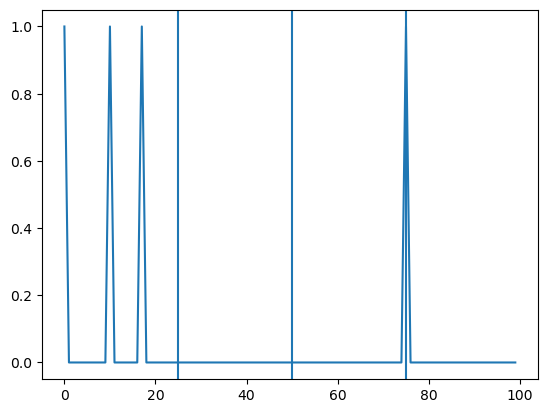

In [30]:
plt.plot(delta_final)
plt.axvline(25)
plt.axvline(75)
plt.axvline(50)

In [31]:
alpha=0.05

In [32]:
def constraint_lhs(deltas, tau_l, tau_u):
    n_samples = deltas.shape[0]
    sum_tau = np.sum(deltas[:, tau_l:tau_u]) / n_samples
    return sum_tau

In [33]:
def possible_taus(tau_k, delta_tau):
    lower= tau_k
    upper= tau_k +delta_tau
    possible=[]
    for i in range(delta_tau+1):
        if upper<=T and lower>=0:
            possible.append((lower, upper))
            lower-=1
            upper-=1
    return possible

# possible_taus(4, 4)

In [34]:
ci_tau = []
for tau_k in tau_final:
    for delta_tau in range(2, T):
        candidate = []
        possible_taus_list = possible_taus(tau_k, delta_tau)
        for tau_l, tau_u in possible_taus_list:
            sum_tau = constraint_lhs(delta_samples, tau_l, tau_u)
            if sum_tau >= 1 - alpha:
                candidate.append([sum_tau, tau_l, tau_u])
        if len(candidate) > 0:
            break

    if len(candidate) == 0:
        ci_tau.append(np.array([0, T]))
    else:
        candidate = np.array(candidate)
        index_max_candidate = np.argmax(candidate[:, 0])
        ci_tau.append(candidate[index_max_candidate, 1:])

In [35]:
ci_tau

[array([0., 2.]), array([ 0., 10.]), array([ 4., 19.]), array([70., 80.])]

In [36]:
sum_beta = np.zeros(T)
sum_gamma = np.zeros(T)
n_smaples_reduced = delta_samples.shape[0]
for g in range(n_smaples_reduced):
    sum_beta += 1 / b_samples[g, :]
    sum_gamma+= r_samples[g, :]/(1+r_samples[g, :])
beta_final = sum_beta / n_smaples_reduced
gamma_final = sum_gamma / n_smaples_reduced

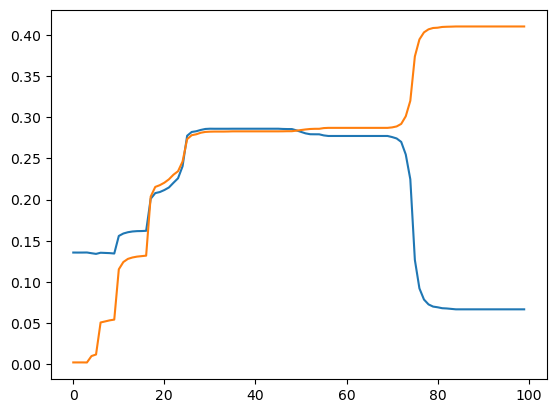

In [37]:
plt.plot(beta_final)
plt.plot(gamma_final)